# (Re-sampled) Modeling - Bike Share System in the SF Bay Area

Author: Owen Hsu

## Table of content

1. Loading and Setup
2. Assessment
3. Spliting Training Set into Training and Validation Sets
4. Baseline Modeling
   * Logistic Regression
   * Decision Tree
   * Random Forest
   * XGBoost
   * Support Vector Machine (SVM)
   * K-Nearest Neighbors (KNN)

## Loading and Setup

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import time
import pickle
import os
# Filter warnings
import warnings
warnings.filterwarnings("ignore")

/Users/chih-kanghsu/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Load the datasets
train_df = pd.read_parquet('data/resampled_train_dataset.parquet')
test_df = pd.read_parquet('data/resampled_test_dataset.parquet')

## Assessment

In [3]:
# Set display options to show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#### Train Data

In [4]:
# Print the shape of the train data
train_df.shape

(1971942, 17)

In [5]:
# Look at the first 5 rows of the train dataset
train_df.head()

,station_id,dock_count,mean_dew_point_f,mean_humidity,mean_sea_level_pressure_inches,mean_visibility_miles,mean_wind_speed_mph,precipitation_inches,cloud_cover,zip_code,weekend,holiday,month,day,hour,minute,usage_rate_category
0,-0.915834,-0.666910,-0.392057,1.249166,1.007851,-1.217929,-1.710234,-0.436715,-0.566383,-0.651909,-0.631934,-0.167764,-1.310991,-1.557247,0.649982,-1.000258,1.0
1,-0.040825,-0.666910,0.775875,0.130813,-0.927883,0.305910,0.712170,-0.436715,-0.117856,-0.548370,-0.631934,-0.167764,0.138593,-0.194967,-1.372796,-1.000258,2.0
2,0.542515,0.337471,0.483892,-0.241972,-1.237600,0.305910,1.620572,-0.436715,0.779197,-0.548370,-0.631934,-0.167764,-0.151324,-0.535537,0.072046,-1.000258,1.0
3,-1.415840,-0.666910,-1.559990,-0.894344,1.085281,0.305910,-1.104633,-0.436715,-1.463436,1.818895,1.582445,-0.167764,-1.600907,0.940267,-1.372796,-1.000258,1.0
4,1.542526,-0.666910,0.629884,0.130813,-1.160171,0.305910,-0.196231,-0.436715,-0.117856,1.818895,1.582445,-0.167764,0.718426,-0.989630,-1.083828,-1.000258,1.0


In [6]:
# Verify the train dataset
train_df.sample(10)

,station_id,dock_count,mean_dew_point_f,mean_humidity,mean_sea_level_pressure_inches,mean_visibility_miles,mean_wind_speed_mph,precipitation_inches,cloud_cover,zip_code,weekend,holiday,month,day,hour,minute,usage_rate_category
1841935,-1.374173,-0.666910,0.775875,0.130813,-0.540736,0.305910,0.409370,-0.436715,-0.566383,1.818895,1.582445,-0.167764,0.428510,-0.762584,0.531567,0.999742,2.0
1963942,1.000853,2.346234,0.775875,-0.521560,-1.005312,0.305910,1.317772,-0.436715,0.779197,-0.548370,-0.631934,-0.167764,0.428510,1.053790,-0.510695,-1.000258,2.0
898299,1.292523,1.341853,1.067858,0.969578,-0.463307,-1.217929,-0.196231,2.289821,1.227724,-0.548370,-0.631934,-0.167764,0.718426,1.053790,-1.083828,0.999742,0.0
979678,0.763963,0.337471,-1.559990,0.317205,1.549857,-1.217929,-1.407434,-0.436715,-1.463436,-0.548370,-0.631934,-0.167764,-1.600907,-1.103154,0.649982,-1.000258,0.0
880482,0.125844,-0.666910,-0.684040,-1.080737,0.001270,0.305910,0.712170,-0.436715,-1.463436,-0.548370,-0.631934,-0.167764,-0.441240,1.394360,0.938951,0.999742,0.0
1192946,1.561351,-0.666910,-0.976024,-0.801148,1.627286,0.305910,-0.801832,-0.436715,-1.463436,-0.548370,-0.631934,-0.167764,-1.021074,-1.103154,-1.178603,-1.000258,0.0
1573708,-0.874167,1.844044,-1.268007,0.317205,-1.005312,0.305910,-1.407434,-0.436715,-0.566383,-0.651909,-0.631934,-0.167764,-1.021074,-1.557247,1.080343,0.999742,2.0
11890,0.125844,-0.666910,-0.830032,-0.521560,1.162710,-0.456009,0.106569,-0.436715,-1.463436,-0.548370,1.582445,-0.167764,-1.600907,0.940267,-0.361407,-1.000258,1.0
1787814,1.067130,2.346234,0.069139,-0.006856,0.156128,0.305910,2.783610,-0.436715,1.156380,-0.548370,1.582445,-0.167764,-0.441240,-1.425666,1.516888,0.999742,2.0
427916,1.167522,0.337471,0.775875,0.783186,-0.850453,0.305910,0.409370,-0.436715,0.330670,-0.548370,-0.631934,-0.167764,0.138593,-0.762584,1.083435,0.999742,1.0


In [7]:
# Get a quick overview of dataset variables
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1971942 entries, 0 to 1971941
Data columns (total 17 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   station_id                      float64
 1   dock_count                      float64
 2   mean_dew_point_f                float64
 3   mean_humidity                   float64
 4   mean_sea_level_pressure_inches  float64
 5   mean_visibility_miles           float64
 6   mean_wind_speed_mph             float64
 7   precipitation_inches            float64
 8   cloud_cover                     float64
 9   zip_code                        float64
 10  weekend                         float64
 11  holiday                         float64
 12  month                           float64
 13  day                             float64
 14  hour                            float64
 15  minute                          float64
 16  usage_rate_category             float64
dtypes: float64(17)
memory usage

In [8]:
# Get a statistical summary of the dataset
train_df.describe()

,station_id,dock_count,mean_dew_point_f,mean_humidity,mean_sea_level_pressure_inches,mean_visibility_miles,mean_wind_speed_mph,precipitation_inches,cloud_cover,zip_code,weekend,holiday,month,day,hour,minute,usage_rate_category
count,1.971942e+06,1.971942e+06,1.971942e+06,1.971942e+06,1.971942e+06,1.971942e+06,1.971942e+06,1.971942e+06,1.971942e+06,1.971942e+06,1.971942e+06,1.971942e+06,1.971942e+06,1.971942e+06,1.971942e+06,1.971942e+06,1.971942e+06
mean,8.773593e-02,4.483389e-02,1.191521e-04,2.860316e-02,1.383199e-02,-3.019775e-02,3.608362e-02,2.915445e-02,4.225776e-02,-5.961359e-02,-2.988570e-02,-1.509725e-02,-6.548925e-03,2.312677e-03,-9.164936e-03,4.662690e-04,1.000000e+00
std,9.843458e-01,1.017243e+00,9.751733e-01,9.790699e-01,1.005182e+00,9.971356e-01,1.016999e+00,1.026244e+00,1.001842e+00,9.578654e-01,9.852389e-01,9.551516e-01,1.013078e+00,9.914811e-01,9.984587e-01,9.999172e-01,8.164968e-01
min,-1.707509e+00,-1.671291e+00,-5.355771e+00,-4.156208e+00,-3.018476e+00,-4.265608e+00,-2.013035e+00,-4.367154e-01,-1.463436e+00,-7.036781e-01,-6.319336e-01,-1.677643e-01,-1.600907e+00,-1.670770e+00,-1.661765e+00,-1.000258e+00,0.000000e+00
25%,-6.658315e-01,-6.669100e-01,-5.380488e-01,-4.283638e-01,-6.955946e-01,3.059103e-01,-8.018325e-01,-4.367154e-01,-1.014910e+00,-5.483704e-01,-6.319336e-01,-1.677643e-01,-1.021074e+00,-8.761069e-01,-9.231153e-01,-1.000258e+00,0.000000e+00
50%,2.091779e-01,-6.669100e-01,4.591747e-02,1.308128e-01,-1.535891e-01,3.059103e-01,-1.962313e-01,-4.367154e-01,-1.178563e-01,-5.483704e-01,-6.319336e-01,-1.677643e-01,1.385930e-01,3.207987e-02,-5.295724e-02,9.997424e-01,1.000000e+00
75%,9.515061e-01,3.374715e-01,7.758753e-01,5.967933e-01,7.755633e-01,3.059103e-01,7.121705e-01,-4.367154e-01,7.791970e-01,-9.185996e-02,1.582445e+00,-1.677643e-01,1.008343e+00,8.267433e-01,8.983044e-01,9.997424e-01,2.000000e+00
max,1.709194e+00,2.346234e+00,2.235791e+00,2.553912e+00,3.021015e+00,7.925107e+00,4.951379e+00,2.289821e+00,2.124777e+00,1.818895e+00,1.582445e+00,5.960742e+00,1.588176e+00,1.734930e+00,1.661372e+00,9.997424e-01,2.000000e+00


#### Test Data

In [9]:
# Print the shape of the test data
test_df.shape

(244581, 17)

In [10]:
# Look at the first 5 rows of the test dataset
test_df.head()

,station_id,dock_count,mean_dew_point_f,mean_humidity,mean_sea_level_pressure_inches,mean_visibility_miles,mean_wind_speed_mph,precipitation_inches,cloud_cover,zip_code,weekend,holiday,month,day,hour,minute,usage_rate_category
0,-0.707499,-0.666910,0.921867,0.969578,-0.927883,0.305910,-1.104633,-0.436715,-0.117856,-0.651909,1.582445,-0.167764,0.718426,1.394360,-0.072439,-1.000258,1.0
1,-0.457496,-1.671291,1.067858,0.596793,0.156128,-0.456009,0.106569,2.289821,0.330670,-0.703678,1.582445,-0.167764,1.008343,1.053790,1.083435,0.999742,1.0
2,0.125844,-0.666910,-0.684040,-0.987540,-0.773024,0.305910,1.317772,-0.436715,-1.014910,-0.548370,-0.631934,-0.167764,-0.441240,-1.103154,-1.372796,-1.000258,0.0
3,0.167511,0.337471,0.337901,1.249166,0.930422,0.305910,0.712170,-0.436715,-0.566383,-0.548370,-0.631934,-0.167764,-1.021074,1.280837,-0.650375,0.999742,2.0
4,0.459181,-0.666910,-0.246066,0.224009,0.233558,0.305910,-0.196231,-0.436715,-1.014910,-0.548370,-0.631934,-0.167764,-1.021074,0.259127,1.083435,-1.000258,0.0


In [11]:
# Verify the test dataset
test_df.sample(10)

,station_id,dock_count,mean_dew_point_f,mean_humidity,mean_sea_level_pressure_inches,mean_visibility_miles,mean_wind_speed_mph,precipitation_inches,cloud_cover,zip_code,weekend,holiday,month,day,hour,minute,usage_rate_category
194035,-1.332505,0.337471,-0.246066,0.503597,-0.308448,-0.456009,1.014971,2.289821,1.227724,1.818895,1.582445,-0.167764,-0.731157,1.053790,1.083435,0.999742,1.0
74695,1.000853,2.346234,0.191909,-0.987540,-0.927883,0.305910,-0.801832,-0.436715,-1.014910,-0.548370,-0.631934,-0.167764,1.008343,-1.670770,1.516888,0.999742,1.0
172676,-0.582497,1.341853,-0.684040,-2.665070,0.543275,0.305910,-0.196231,-0.436715,-1.463436,-0.703678,-0.631934,-0.167764,-0.441240,-0.081443,1.227919,0.999742,1.0
55062,-1.415840,-0.666910,-0.100074,-0.521560,-0.231018,0.305910,-0.801832,-0.436715,0.779197,1.818895,-0.631934,-0.167764,1.008343,0.032080,1.227919,-1.000258,0.0
156357,-0.749166,-0.666910,-1.559990,-0.801148,1.394998,0.305910,-1.407434,-0.436715,-1.014910,-0.651909,-0.631934,-0.167764,1.298260,0.145603,-0.939344,0.999742,1.0
44200,0.959186,0.337471,0.629884,1.062774,-1.392459,-1.217929,0.409370,2.289821,2.124777,-0.548370,-0.631934,-0.167764,1.008343,1.734930,0.361014,0.999742,2.0
33251,0.334179,0.337471,-0.100074,-0.148776,-0.618165,0.305910,1.620572,-0.436715,0.330670,-0.548370,1.582445,-0.167764,-0.151324,0.713220,-0.650375,-1.000258,1.0
236708,-1.374173,-0.666910,1.213850,0.224009,-1.547318,-0.456009,-0.499032,-0.436715,0.330670,1.818895,1.582445,-0.167764,0.718426,-0.308490,-1.228312,-1.000258,2.0
198618,0.459181,-0.666910,-2.289948,-0.241972,1.859574,0.305910,-1.407434,-0.436715,-1.014910,-0.548370,1.582445,-0.167764,-1.600907,-1.443724,1.516888,0.999742,1.0
87870,-0.207493,-0.666910,-3.311889,-1.826305,0.852993,0.305910,-0.801832,-0.436715,-1.463436,-0.091860,-0.631934,5.960742,-1.600907,-1.670770,-0.794860,0.999742,1.0


In [12]:
# Get a quick overview of dataset variables
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244581 entries, 0 to 244580
Data columns (total 17 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   station_id                      244581 non-null  float64
 1   dock_count                      244581 non-null  float64
 2   mean_dew_point_f                244581 non-null  float64
 3   mean_humidity                   244581 non-null  float64
 4   mean_sea_level_pressure_inches  244581 non-null  float64
 5   mean_visibility_miles           244581 non-null  float64
 6   mean_wind_speed_mph             244581 non-null  float64
 7   precipitation_inches            244581 non-null  float64
 8   cloud_cover                     244581 non-null  float64
 9   zip_code                        244581 non-null  float64
 10  weekend                         244581 non-null  float64
 11  holiday                         244581 non-null  float64
 12  month           

In [13]:
# Get a statistical summary of the dataset
test_df.describe()

,station_id,dock_count,mean_dew_point_f,mean_humidity,mean_sea_level_pressure_inches,mean_visibility_miles,mean_wind_speed_mph,precipitation_inches,cloud_cover,zip_code,weekend,holiday,month,day,hour,minute,usage_rate_category
count,244581.000000,244581.000000,244581.000000,244581.000000,244581.000000,244581.000000,244581.000000,244581.000000,244581.000000,244581.000000,244581.000000,244581.000000,244581.000000,244581.000000,244581.000000,244581.000000,244581.000000
mean,0.002867,0.001113,-0.002031,-0.000129,0.000780,-0.001269,-0.001359,-0.002743,0.000213,-0.001931,-0.000180,0.003050,0.000015,0.000157,-0.001053,-0.001578,1.070795
std,0.998805,0.999587,0.999342,1.001037,0.999408,1.003939,1.000849,0.997453,0.999556,0.998481,0.999916,1.008794,1.001538,0.998686,0.999236,1.000001,0.568553
min,-1.707509,-1.671291,-5.355771,-4.156208,-3.018476,-4.265608,-2.013035,-0.436715,-1.463436,-0.703678,-0.631934,-0.167764,-1.600907,-1.670770,-1.661765,-1.000258,0.000000
25%,-0.790833,-0.666910,-0.538049,-0.521560,-0.695595,0.305910,-0.801832,-0.436715,-1.014910,-0.548370,-0.631934,-0.167764,-0.731157,-0.876107,-0.939344,-1.000258,1.000000
50%,0.084177,-0.666910,0.045917,0.037617,-0.153589,0.305910,-0.196231,-0.436715,-0.117856,-0.548370,-0.631934,-0.167764,0.138593,0.032080,0.072046,-1.000258,1.000000
75%,0.875852,0.337471,0.775875,0.596793,0.698134,0.305910,0.712170,-0.436715,0.779197,-0.091860,1.582445,-0.167764,1.008343,0.826743,0.794467,0.999742,1.000000
max,1.709194,2.346234,2.235791,2.553912,3.021015,7.925107,4.951379,2.289821,2.124777,1.818895,1.582445,5.960742,1.588176,1.734930,1.661372,0.999742,2.000000


## Spliting Training Set into Training and Validation Sets

In [14]:
# Separate features and target variable from the train set
X_train_full = train_df.drop(columns=['usage_rate_category'])
y_train_full = train_df['usage_rate_category']

# Split the training dataset into training and validation subsets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Separate features and target variable from the test set
X_test = test_df.drop(columns=['usage_rate_category'])
y_test = test_df['usage_rate_category']

# Check the shapes of the datasets
print(f'Shape of test set: {X_train.shape}')
print(f'Shape of validation set: {X_val.shape}')
print(f'Shape of train set: {X_test.shape}')

Shape of test set: (1577553, 16)
Shape of validation set: (394389, 16)
Shape of train set: (244581, 16)


## Baseline Modeling

#### Logistic Regression

Let's fit a logistic regression model on the data and analyze the test and train accuracy.

In [15]:
# Start the timer
start_time = time.time()

# Initialize the model
logreg = LogisticRegression(random_state=42)

# Fitting a model
logreg.fit(X_train, y_train)

# Get class predictions
y_pred_logreg = logreg.predict(X_val)

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Saving metrics for plotting
accuracy_logreg = accuracy_score(y_val, y_pred_logreg)
precision_logreg = precision_score(y_val, y_pred_logreg, average='macro')
recall_logreg = recall_score(y_val, y_pred_logreg, average='macro')
f1_logreg = f1_score(y_val, y_pred_logreg, average='macro')

# Training and test score
print('Logistic Regression')
print(f"Train score: {logreg.score(X_train, y_train)}")
print(f"Test score: {logreg.score(X_val, y_val)}")

# Generate confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred_logreg))

# Classification report 
print("\nClassification Report:")
print(classification_report(y_val, y_pred_logreg))

# Print the elapsed time
print(f"\nElapsed time: {elapsed_time:.2f} seconds")

Logistic Regression
Train score: 0.40006833367880507
Test score: 0.39857348962572486

Confusion Matrix:
[[47367 41486 42998]
 [35148 59059 37068]
 [40919 39577 50767]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.38      0.36      0.37    131851
         1.0       0.42      0.45      0.44    131275
         2.0       0.39      0.39      0.39    131263

    accuracy                           0.40    394389
   macro avg       0.40      0.40      0.40    394389
weighted avg       0.40      0.40      0.40    394389


Elapsed time: 3.49 seconds


#### Decision Tree

In [16]:
# Start the timer
start_time = time.time()

# Initialize the model
dt_model = DecisionTreeClassifier(random_state=42)

# Fitting a model
dt_model.fit(X_train, y_train);

# Get class predictions
y_pred_dt_model = dt_model.predict(X_val)

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Saving metrics for plotting
accuracy_dt_model = accuracy_score(y_val, y_pred_dt_model)
precision_dt_model = precision_score(y_val, y_pred_dt_model, average='macro')
recall_dt_model = recall_score(y_val, y_pred_dt_model, average='macro')
f1_dt_model = f1_score(y_val, y_pred_dt_model, average='macro')

# Evaluate its classification accuracy
print('Decision Tree:')
print(f'Train score: {dt_model.score(X_train, y_train)}')
print(f'Test score: {dt_model.score(X_val, y_val)}')

# Generate confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred_dt_model))

# Classification report 
print("\nClassification Report:")
print(classification_report(y_val, y_pred_dt_model))

# Print the elapsed time
print(f"\nElapsed time: {elapsed_time:.2f} seconds")

Decision Tree:
Train score: 1.0
Test score: 0.9227260395193578

Confusion Matrix:
[[122276   4639   4936]
 [  4543 120938   5794]
 [  5096   5468 120699]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93    131851
         1.0       0.92      0.92      0.92    131275
         2.0       0.92      0.92      0.92    131263

    accuracy                           0.92    394389
   macro avg       0.92      0.92      0.92    394389
weighted avg       0.92      0.92      0.92    394389


Elapsed time: 24.77 seconds


#### Random Forest

In [17]:
# Start the timer
start_time = time.time()

# Initialize the model
random_forest_model = RandomForestClassifier(random_state=42)

# Fitting a model
random_forest_model.fit(X_train, y_train)

# Get class predictions
y_pred_random_forest_model = random_forest_model.predict(X_val)

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Saving metrics for plotting
accuracy_random_forest_model = accuracy_score(y_val, y_pred_random_forest_model)
precision_random_forest_model = precision_score(y_val, y_pred_random_forest_model, average='macro')
recall_random_forest_model = recall_score(y_val, y_pred_random_forest_model, average='macro')
f1_random_forest_model = f1_score(y_val, y_pred_random_forest_model, average='macro')

# Evaluate its classification accuracy
print('Random Forest:')
print(f'Train score: {random_forest_model.score(X_train, y_train)}')
print(f'Test score: {random_forest_model.score(X_val, y_val)}')

# Generate confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred_random_forest_model))

# Classification report 
print("\nClassification Report:")
print(classification_report(y_val, y_pred_random_forest_model))

# Print the elapsed time
print(f"\nElapsed time: {elapsed_time:.2f} seconds")

Random Forest:
Train score: 0.9999917593893834
Test score: 0.9453635877268383

Confusion Matrix:
[[125932   3374   2545]
 [  3866 122333   5076]
 [  2302   4385 124576]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.95    131851
         1.0       0.94      0.93      0.94    131275
         2.0       0.94      0.95      0.95    131263

    accuracy                           0.95    394389
   macro avg       0.95      0.95      0.95    394389
weighted avg       0.95      0.95      0.95    394389


Elapsed time: 876.24 seconds


#### XGBoost

In [18]:
# Start the timer
start_time = time.time()

# Initialize the model
xgbc = XGBClassifier()

# Fitting a model
xgbc.fit(X_train, y_train)

# Get class predictions
y_pred_xgbc = xgbc.predict(X_val)

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Saving metrics for plotting
accuracy_xgbc = accuracy_score(y_val, y_pred_xgbc)
precision_xgbc = precision_score(y_val, y_pred_xgbc, average='macro')
recall_xgbc = recall_score(y_val, y_pred_xgbc, average='macro')
f1_xgbc = f1_score(y_val, y_pred_xgbc, average='macro')

# Evaluate its classification accuracy
print('XGBoost:')
print(f'Train score: {xgbc.score(X_train, y_train)}')
print(f'Test score: {xgbc.score(X_val, y_val)}')

# Generate confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred_xgbc))

# Classification report 
print("\nClassification Report:")
print(classification_report(y_val, y_pred_xgbc))

# Print the elapsed time
print(f"\nElapsed time: {elapsed_time:.2f} seconds")

XGBoost:
Train score: 0.7356760755423114
Test score: 0.734267436465013

Confusion Matrix:
[[ 91600  25601  14650]
 [  6582 113798  10895]
 [ 15027  32047  84189]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.69      0.75    131851
         1.0       0.66      0.87      0.75    131275
         2.0       0.77      0.64      0.70    131263

    accuracy                           0.73    394389
   macro avg       0.75      0.73      0.73    394389
weighted avg       0.75      0.73      0.73    394389


Elapsed time: 21.13 seconds


#### Support Vector Machine (SVM)

Below is the code for SVM, this model can be trained in the future.

In [ ]:
# Start the timer
# start_time = time.time()

# Initialize the model
# svm = SVC(random_state=42)

# Fitting a model
# svm.fit(X_train, y_train)

# Stop the timer
# end_time = time.time()

# Calculate the elapsed time
# elapsed_time = end_time - start_time

# Evaluate its classification accuracy
# print('Support Vector Machine (SVM):')
# print(f'Train score: {svm.score(X_train, y_train)}')
# print(f'Test score: {svm.score(X_val, y_val)}')

# Get class predictions
# y_pred_svm = svm.predict(X_val)

# Generate confusion matrix
# print("\nConfusion Matrix:")
# print(confusion_matrix(y_val, y_pred_svm))

# Classification report 
# print("\nClassification Report:")
# print(classification_report(y_val, y_pred_svm))

# Print the elapsed time
# print(f"\nElapsed time: {elapsed_time:.2f} seconds")

#### K-Nearest Neighbors (KNN)

Below is the code for KNN, this model can be trained in the future.

In [ ]:
# Start the timer
# start_time = time.time()

# Initialize the model
# KNN_model = KNeighborsClassifier(n_neighbors=3)

# Fitting a model
# KNN_model.fit(X_train, y_train)

# Stop the timer
# end_time = time.time()

# Calculate the elapsed time
# elapsed_time = end_time - start_time

# Evaluate its classification accuracy
# print('KNN:')
# print(f'Train score: {KNN_model.score(X_train, y_train)}')
# print(f'Test score: {KNN_model.score(X_val, y_val)}')

# Get class predictions
# y_pred_KNN_model = KNN_model.predict(X_val)

# Generate confusion matrix
# print("\nConfusion Matrix:")
# print(confusion_matrix(y_val, y_pred_KNN_model))

# Classification report 
# print("\nClassification Report:")
# print(classification_report(y_val, y_pred_KNN_model))

# Print the elapsed time
# print(f"\nElapsed time: {elapsed_time:.2f} seconds")

#### Summary - Baseline Models

Let's review the training and testing scores, as well as the runtime for each model.

| Model               | Train Score (%) | Test Score (%) | Elapsed Time (seconds) |
|---------------------|-----------------|----------------|------------------------|
| Logistic Regression | 40.00%          | 39.85%         | 3.49                   |
| Decision Tree       | 100.00%         | 92.27%         | 24.77                  |
| Random Forest       | 99.99%          | 94.53%         | 876.24                 |
| XGBoost             | 73.56%          | 73.42%         | 21.13                  |


**Observation:**

Based on the train and test socres, the baseline baseline decision tree model and random forest model are overfitting.

We can also compare the classification report for each model.

In [19]:
# Create an empty DataFrame to store the metrics
model_metrics_df = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Add the metrics for the baseline models
model_metrics_df.loc['Logistic Regression'] = [accuracy_logreg, precision_logreg, recall_logreg, f1_logreg]
model_metrics_df.loc['Decision Tree'] = [accuracy_dt_model, precision_dt_model, recall_dt_model, f1_dt_model]
model_metrics_df.loc['Random Forest'] = [accuracy_random_forest_model, precision_random_forest_model, recall_random_forest_model, f1_random_forest_model]
model_metrics_df.loc['XGBoost'] = [accuracy_xgbc, precision_xgbc, recall_xgbc, f1_xgbc]

# Show the comparison table
model_metrics_df

,Accuracy,Precision,Recall,F1 Score
Logistic Regression,0.398573,0.397752,0.398631,0.397902
Decision Tree,0.922726,0.922721,0.922719,0.922720
Random Forest,0.945364,0.945339,0.945349,0.945334
XGBoost,0.734267,0.746696,0.734322,0.732693


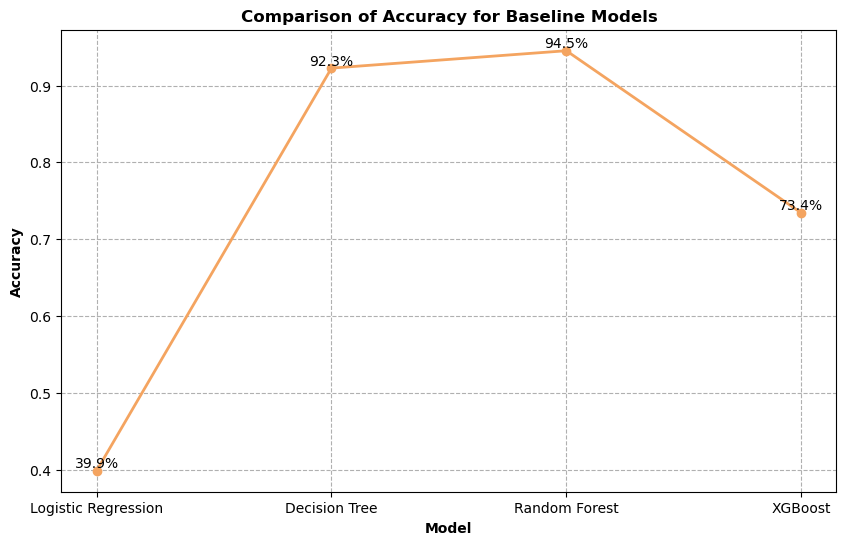

In [20]:
# Creating a list of model names
# Creating a list of model's corresponding accuracy scores
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
accuracy_scores = [accuracy_logreg, accuracy_dt_model, accuracy_random_forest_model, accuracy_xgbc]

# Plotting a line graph to compare the accuracy scores of each model
plt.figure(figsize=(10, 6))
plt.plot(models, accuracy_scores, color='sandybrown', marker='o', linestyle='-', linewidth=2)
plt.xlabel('Model', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.title('Comparison of Accuracy for Baseline Models', fontweight='bold')

# Add accuracy score labels
for i, score in enumerate(accuracy_scores):
    plt.text(models[i], score, f"{score*100:.1f}%", ha='center', va='bottom')

# Add grid lines
plt.grid(True, which='both', linestyle='--')  
plt.show()

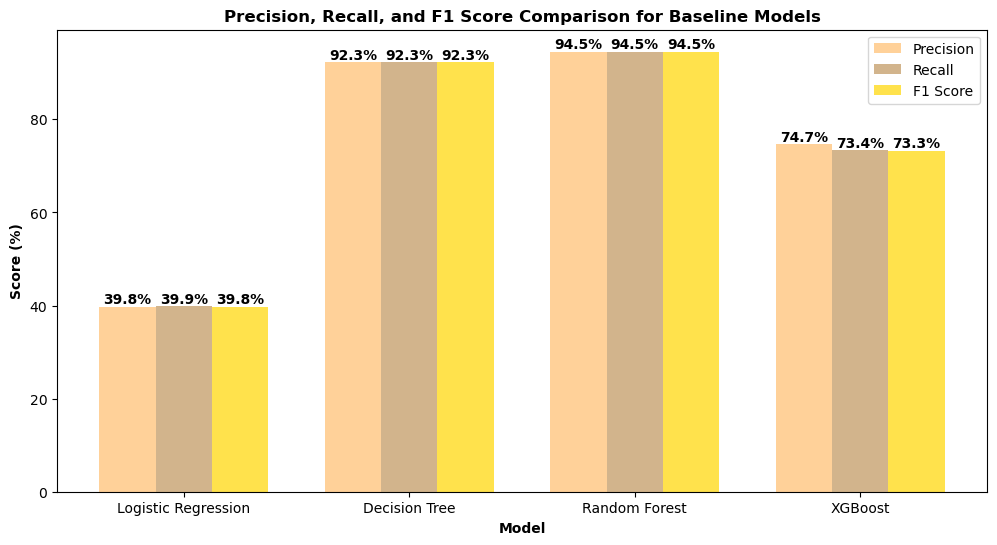

In [21]:
# Creating a list of model names
# Creating a list of model's corresponding precision, recall, and F1 scores
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
precision_scores = [precision_logreg, precision_dt_model, precision_random_forest_model, precision_xgbc]
recall_scores = [recall_logreg, recall_dt_model, recall_random_forest_model, recall_xgbc]
f1_scores = [f1_logreg, f1_dt_model, f1_random_forest_model, f1_xgbc]

# Converting scores to percentages with two decimal place
precision_scores_pct = [round(score * 100, 2) for score in precision_scores]
recall_scores_pct = [round(score * 100, 2) for score in recall_scores]
f1_scores_pct = [round(score * 100, 2) for score in f1_scores]

# Set the positions and width for the bars
pos = np.arange(len(models))
width = 0.25

# Plotting the bar graph for precision with an orange color theme
plt.figure(figsize=(12, 6))
plt.bar(pos, precision_scores_pct, width, color='darkorange', alpha=0.4, label='Precision')

# Plotting the bar graph for recall with a darker orange color
plt.bar(pos + width, recall_scores_pct, width, color='tan', label='Recall')

# Plotting the bar graph for F1 score with a much darker orange color
plt.bar(pos + 2 * width, f1_scores_pct, width, color='gold', alpha=0.7, label='F1 Score')

# Add xticks on the middle of the group bars
plt.xlabel('Model', fontweight='bold')
plt.ylabel('Score (%)', fontweight='bold')
plt.title('Precision, Recall, and F1 Score Comparison for Baseline Models', fontweight='bold')
plt.xticks(pos + width, models, rotation=360)
plt.legend()

# Adding score labels to the bars
for i in range(len(models)):
    plt.text(pos[i], precision_scores_pct[i], f"{precision_scores_pct[i]:.1f}%", ha='center', va='bottom', fontweight='bold')
    plt.text(pos[i] + width, recall_scores_pct[i], f"{recall_scores_pct[i]:.1f}%", ha='center', va='bottom', fontweight='bold')
    plt.text(pos[i] + 2 * width, f1_scores_pct[i], f"{f1_scores_pct[i]:.1f}%", ha='center', va='bottom', fontweight='bold')

plt.show()

## Hyperparameter Optimization

In [102]:
# This code will explain each and every step of the model fitting code in terms of time spent
from sklearn.base import BaseEstimator
from tqdm import tqdm

class TqdmGridSearchCV(GridSearchCV):
    def __init__(self, estimator, param_grid, **kwargs):
        super().__init__(estimator, param_grid, **kwargs)
    def fit(self, X_train_combined, y_train=None, **fit_params):
        total = np.prod([len(v) for v in self.param_grid.values()])
        with tqdm(total=total, desc="GridSearch") as pbar:
            def score(estimator, X_train_combined, y_train):
                result = self.scoring(estimator, X_train_combined, y_train)
                pbar.update(1)
                return result
            self.scoring_ = score if self.scoring else None
            return super().fit(X_train_combined, y_train, **fit_params)

#### Logistic Regression

c 0.001 , train 0.4000594591750642 , test 0.39860391643783166 , diff 0.0014555427372325291
c 0.01 , train 0.40006960146505377 , test 0.39857095405804926 , diff 0.0014986474070045053
c 0.1 , train 0.40007023535817815 , test 0.3985760251934004 , diff 0.0014942101647777428
c 1.0 , train 0.40006833367880507 , test 0.39857348962572486 , diff 0.001494844053080202
c 10.0 , train 0.40006833367880507 , test 0.39857348962572486 , diff 0.001494844053080202
c 100.0 , train 0.40006833367880507 , test 0.39857348962572486 , diff 0.001494844053080202


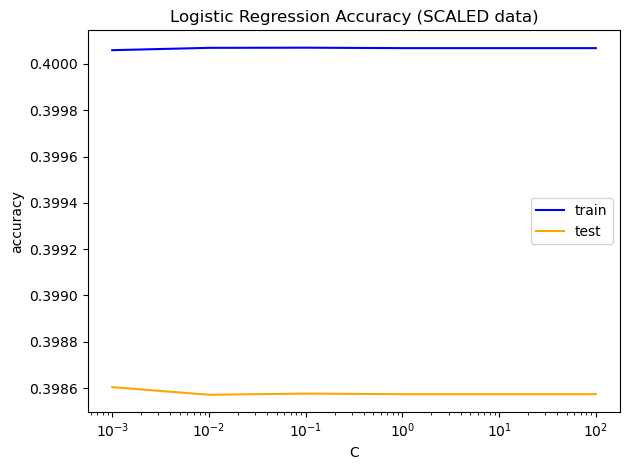

In [110]:
C_range = np.array([.001,.01, 0.1, 1, 10, 100])
train_accs = []
test_accs = []

# Loop over different C
for c in C_range:

    # Instantiate & fit
    logreg = LogisticRegression(C = c, random_state=42)
    logreg.fit(X_train, y_train)

    # Evaluate on train & test data
    train_accs.append(logreg.score(X_train, y_train))
    test_accs.append(logreg.score(X_val, y_val))
    train_score = logreg.score(X_train, y_train)
    test_score = logreg.score(X_val, y_val)
    
    print("c", c, ", train", train_score, ", test", test_score
          , ", diff", train_score - test_score)

# Plot the results
plt.plot(C_range, train_accs, c='blue', label='train')
plt.plot(C_range, test_accs, c='orange', label='test')
plt.legend()
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('accuracy')
plt.title('Logistic Regression Accuracy (SCALED data)')

plt.tight_layout()
plt.show()

**Observation:** <br/>
According to the plot above, the train and test score stabilize after `C` > 1.

In [112]:
# Start the timer
start_time = time.time()

# Initialize the model with a solver that supports both 'l1' and 'l2' penalties
logreg = LogisticRegression(random_state=42, solver='liblinear')

# Define the hyperparameter grid to search
estimators = {
    'C': [0.001, 0.01, 0.1, 1.0],  
    'penalty': ['l1', 'l2']       
}

# Initialize GridSearchCV with the model, parameter grid, and scoring metric: f1-score
grid = GridSearchCV(logreg, estimators, cv=5, scoring='f1_macro', n_jobs=-1)

# Perform the hyperparameter search on the validation data
fittedgrid = grid.fit(X_train, y_train)

# Get the best hyperparameters and the corresponding model
best_params = fittedgrid.best_params_
best_model = fittedgrid.best_estimator_

# Make predictions using the best model
y_pred_logreg_tuned = best_model.predict(X_val)

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Saving metrics for plotting
accuracy_logreg_tuned = accuracy_score(y_val, y_pred_logreg_tuned)
precision_logreg_tuned = precision_score(y_val, y_pred_logreg_tuned, average='macro')
recall_logreg_tuned = recall_score(y_val, y_pred_logreg_tuned, average='macro')
f1_logreg_tuned = f1_score(y_val, y_pred_logreg_tuned, average='macro')

# Training and test score
print('Tuned Logistic Regression')
print(f"Train score: {best_model.score(X_train, y_train)}")
print(f"Test score: {best_model.score(X_val, y_val)}")

# Best hyperparameters
print("\nBest Hyperparameters:")
print(best_params) 

# Generate confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred_logreg_tuned))

# Classification report 
print("\nClassification Report:")
print(classification_report(y_val, y_pred_logreg_tuned))

# Print the elapsed time
print(f"\nElapsed time: {elapsed_time:.2f} seconds")

/Users/chih-kanghsu/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/chih-kanghsu/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/chih-kanghsu/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/chih-kanghsu/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/chih-kanghsu/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked

Tuned Logistic Regression
Train score: 0.40032949764603787
Test score: 0.39876872833674365

Best Hyperparameters:
{'C': 0.001, 'penalty': 'l1'}

Confusion Matrix:
[[47473 41970 42408]
 [35108 59722 36445]
 [41022 40166 50075]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.38      0.36      0.37    131851
         1.0       0.42      0.45      0.44    131275
         2.0       0.39      0.38      0.38    131263

    accuracy                           0.40    394389
   macro avg       0.40      0.40      0.40    394389
weighted avg       0.40      0.40      0.40    394389


Elapsed time: 204.10 seconds


#### Decision Tree

Based on the train and test socre for baseline decision tree model, it is overfitting. <br/>
We are going to implement three pre-pruning techniques that can mitigate overfitting in decision tree model: 
* Using `max_depth`: we can limit the number of consecutive splits that can be made. This directly limits the overall complexity of the tree. It can't develop overly long and complex branches to fit each individual data point.
* Using `min_samples_leaf`: we can put a lower bound on the number of data points each region must cover. This forces the tree to fit regions around larger amounts of data, also preventing specific regions to fit around each individual data point.
* Using `min_samples_split`: we can set the minimum number of samples required to split an internal node. It helps prevent overfitting by ensuring that the tree does not create overly specific splits based on very small subsets of the data. 

First, we are going to find the `max_depth` and try to optimize the model. 

d 1 , train 0.3910752919236311 , test 0.3906954808577318 , diff 0.0003798110658992937
d 5 , train 0.4905565771799743 , test 0.4904649977560226 , diff 9.157942395171537e-05
d 10 , train 0.6107712387476046 , test 0.6103162106448202 , diff 0.0004550281027844161
d 15 , train 0.739524440700249 , test 0.7309509139453687 , diff 0.008573526754880323
d 20 , train 0.8670149275491853 , test 0.8392196536921669 , diff 0.02779527385701841
d 25 , train 0.9467834044244472 , test 0.8955827875523912 , diff 0.051200616872056015
d 30 , train 0.9838414303671572 , test 0.9166964595868546 , diff 0.06714497078030257
d 35 , train 0.9964933032360878 , test 0.9221073610065189 , diff 0.07438594222956885
d 40 , train 0.9994789398517832 , test 0.9222392105256485 , diff 0.07723972932613465
d 45 , train 0.9999651358781607 , test 0.922566298755797 , diff 0.07739883712236373
d 50 , train 0.9999993661068757 , test 0.9225434786467168 , diff 0.07745588746015886


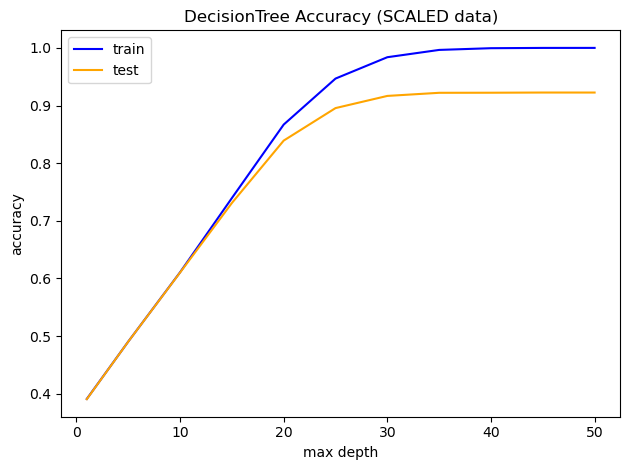

In [91]:
depth_values = [1,5,10,15,20,25,30,35,40,45,50]
train_accs = []
test_accs = []

# Loop over different max_depths
for d in depth_values:

    # Instantiate & fit
    dt_model = DecisionTreeClassifier(max_depth = d)
    dt_model.fit(X_train, y_train)

    # Evaluate on train & test data
    train_accs.append( dt_model.score(X_train, y_train) )
    test_accs.append( dt_model.score(X_val, y_val) )
    train_score = dt_model.score(X_train, y_train)
    test_score = dt_model.score(X_val, y_val)
    
    print("d", d, ", train", train_score, ", test", test_score
          , ", diff", train_score - test_score)

# Plot the results
plt.plot(depth_values, train_accs, c='blue', label='train')
plt.plot(depth_values, test_accs, c='orange', label='test')
plt.legend()
plt.xlabel('max depth')
plt.ylabel('accuracy')
plt.title('DecisionTree Accuracy (SCALED data)')

plt.tight_layout()
plt.show()

**Observation:** <br/>
According to the plot above, the model start overfitting around `max_depth` = 20. Our model performs better where `max_depth` between 20 to 25. 

Second, let's we will find the `min_samples_leaf` and try to optimize the model.

l 1 , train 1.0 , test 0.9226423657860641 , diff 0.07735763421393593
l 100 , train 0.7894029550829671 , test 0.7804350527017742 , diff 0.008967902381192938
l 200 , train 0.7451134763776558 , test 0.739627626531166 , diff 0.00548584984648981
l 500 , train 0.6875388655721868 , test 0.6850317833408133 , diff 0.0025070822313735253
l 1000 , train 0.6500390161218038 , test 0.6484333995116497 , diff 0.0016056166101541258


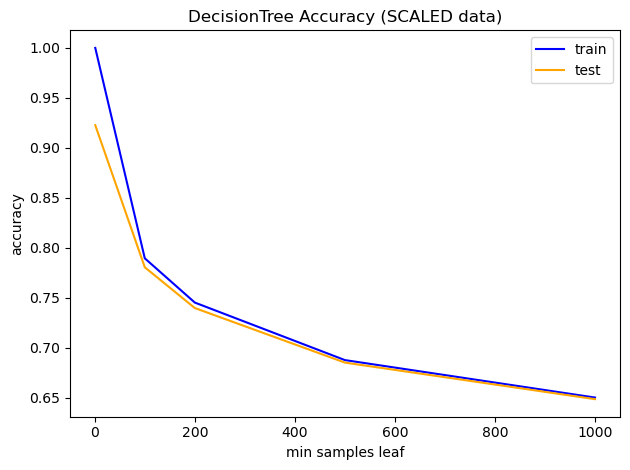

In [100]:
leaf_values = [1, 100, 200, 500, 1000]
train_accs = []
test_accs = []

# Loop over different leaf_values
for l in leaf_values:

    # Instantiate & fit
    dt_model = DecisionTreeClassifier(min_samples_leaf = l)
    dt_model.fit(X_train, y_train)

    # Evaluate on train & test data
    train_accs.append( dt_model.score(X_train, y_train) )
    test_accs.append( dt_model.score(X_val, y_val) )
    train_score = dt_model.score(X_train, y_train)
    test_score = dt_model.score(X_val, y_val)
    
    print("l", l, ", train", train_score, ", test", test_score
          , ", diff", train_score - test_score)

# Plot the results
plt.plot(leaf_values, train_accs, c='blue', label='train')
plt.plot(leaf_values, test_accs, c='orange', label='test')
plt.legend()
plt.xlabel('min samples leaf')
plt.ylabel('accuracy')
plt.title('DecisionTree Accuracy (SCALED data)')

plt.tight_layout()
plt.show()

**Observation:** <br/>
According to the plot above, the overfitting issue stabilize after `min_samples_leaf` reaches 50.

Last, we will find the `min_samples_split` and try to optimize the model.

s 2 , train 1.0 , test 0.9225257296729878 , diff 0.07747427032701215
s 50 , train 0.9040932380718746 , test 0.8773571271004009 , diff 0.02673611097147366
s 100 , train 0.8653870900058508 , test 0.846014975062692 , diff 0.019372114943158825
s 200 , train 0.8248711770698037 , test 0.811848200634399 , diff 0.013022976435404732
s 1000 , train 0.7242285996096486 , test 0.7196042485971972 , diff 0.0046243510124514


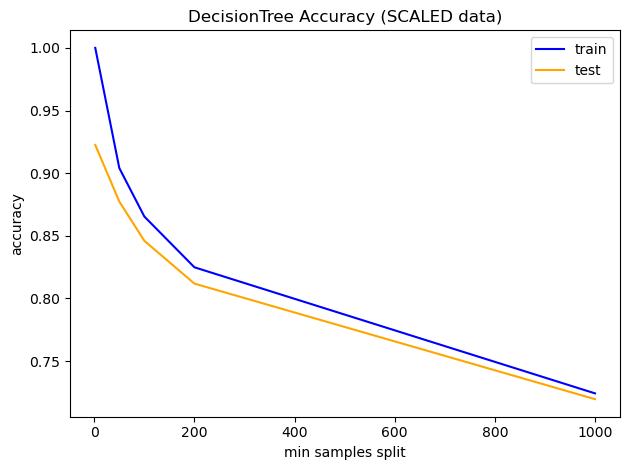

In [98]:
split_values = [2, 50, 100, 200, 1000]
train_accs = []
test_accs = []

# Loop over different split_values
for s in split_values:

    # Instantiate & fit
    dt_model = DecisionTreeClassifier(min_samples_split = s)
    dt_model.fit(X_train, y_train)

    # Evaluate on train & test data
    train_accs.append( dt_model.score(X_train, y_train) )
    test_accs.append( dt_model.score(X_val, y_val) )
    train_score = dt_model.score(X_train, y_train)
    test_score = dt_model.score(X_val, y_val)
    
    print("s", s, ", train", train_score, ", test", test_score
          , ", diff", train_score - test_score)

# Plot the results
plt.plot(split_values, train_accs, c='blue', label='train')
plt.plot(split_values, test_accs, c='orange', label='test')
plt.legend()
plt.xlabel('min samples split')
plt.ylabel('accuracy')
plt.title('DecisionTree Accuracy (SCALED data)')

plt.tight_layout()
plt.show()

**Observation:** <br/>
According to the plot, the trend of how the accuracy and overfitting issue change along with `min_samples_split` is similar to the previous plot for `min_samples_leaf`.

In [85]:
# Start the timer
start_time = time.time()

# Initialize the model with a solver that supports both 'l1' and 'l2' penalties
dt_model = DecisionTreeClassifier(random_state=42)

# Define the hyperparameter grid to search
estimators = {
    'max_depth': [20, 25],
    'min_samples_leaf': [50, 100, 200],
    'min_samples_split': [50, 100, 200]              
}

# Initialize GridSearchCV with the model, parameter grid, and scoring metric: f1-score
grid = GridSearchCV(dt_model, estimators, cv=5, scoring='f1_macro', n_jobs=-1)

# Perform the hyperparameter search on the validation data
fittedgrid = grid.fit(X_train, y_train)

# Get the best hyperparameters and the corresponding model
best_params = fittedgrid.best_params_
best_model = fittedgrid.best_estimator_

# Make predictions using the best model
y_pred_dt_model_tuned = best_model.predict(X_val)

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Saving metrics for plotting
accuracy_dt_model_tuned = accuracy_score(y_val, y_pred_dt_model_tuned)
precision_dt_model_tuned = precision_score(y_val, y_pred_dt_model_tuned, average='macro')
recall_dt_model_tuned = recall_score(y_val, y_pred_dt_model_tuned, average='macro')
f1_dt_model_tuned = f1_score(y_val, y_pred_dt_model_tuned, average='macro')

# Training and test score
print('Tuned Decision Tree')
print(f"Train score: {best_model.score(X_train, y_train)}")
print(f"Test score: {best_model.score(X_val, y_val)}")

# Best hyperparameters
print("\nBest Hyperparameters:")
print(best_params) 

# Generate confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred_dt_model_tuned))

# Classification report 
print("\nClassification Report:")
print(classification_report(y_val, y_pred_dt_model_tuned))

# Print the elapsed time
print(f"\nElapsed time: {elapsed_time:.2f} seconds")

/Users/chih-kanghsu/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/chih-kanghsu/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/chih-kanghsu/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/chih-kanghsu/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/chih-kanghsu/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked

Tuned Logistic Regression
Train score: 0.8272761675835931
Test score: 0.8120764017252002

Best Hyperparameters:
{'max_depth': 25, 'min_samples_leaf': 50, 'min_samples_split': 50}

Confusion Matrix:
[[111551  11398   8902]
 [ 12726 102733  15816]
 [ 10194  15079 105990]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.85      0.84    131851
         1.0       0.80      0.78      0.79    131275
         2.0       0.81      0.81      0.81    131263

    accuracy                           0.81    394389
   macro avg       0.81      0.81      0.81    394389
weighted avg       0.81      0.81      0.81    394389


Elapsed time: 349.84 seconds


#### Random Forest

d 1 , train 0.4036897650982249 , test 0.40267096698944443 , diff 0.001018798108780472
d 10 , train 0.6132332796425857 , test 0.6111909814928915 , diff 0.002042298149694144
d 20 , train 0.9224273289074916 , test 0.8956461767442804 , diff 0.026781152163211197
d 25 , train 0.9824925057985373 , test 0.9378507007041271 , diff 0.04464180509441018
d 30 , train 0.9982986308542408 , test 0.9450314283613387 , diff 0.053267202492902066
d 35 , train 0.9999302717563213 , test 0.9448666164624266 , diff 0.055063655293894676
d 50 , train 0.9999923932825078 , test 0.9451962402602506 , diff 0.054796153022257155


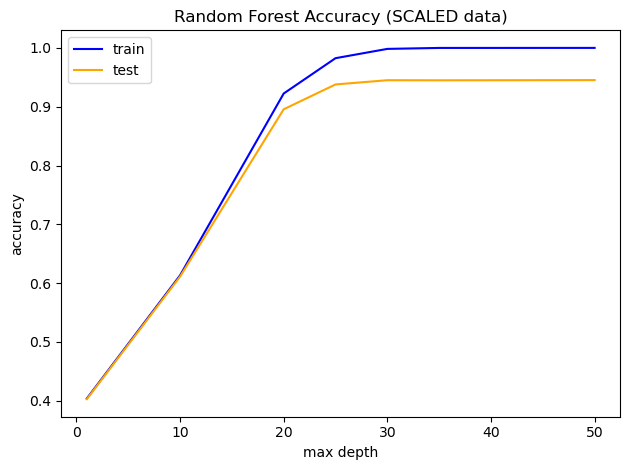

In [114]:
depth_values = [1,10,20,25,30,35,50]
train_accs = []
test_accs = []

# Loop over different max_depths
for d in depth_values:

    # Instantiate & fit
    random_forest_model = RandomForestClassifier(max_depth = d, random_state=42)
    random_forest_model.fit(X_train, y_train)

    # Evaluate on train & test data
    train_accs.append(random_forest_model.score(X_train, y_train))
    test_accs.append(random_forest_model.score(X_val, y_val))
    train_score = random_forest_model.score(X_train, y_train)
    test_score = random_forest_model.score(X_val, y_val)
    
    print("d", d, ", train", train_score, ", test", test_score
          , ", diff", train_score - test_score)

# Plot the results
plt.plot(depth_values, train_accs, c='blue', label='train')
plt.plot(depth_values, test_accs, c='orange', label='test')
plt.legend()
plt.xlabel('max depth')
plt.ylabel('accuracy')
plt.title('Random Forest Accuracy (SCALED data)')

plt.tight_layout()
plt.show()

**Observation:** <br/>
According to the plot above, the model start overfitting around `max_depth` = 20. Our model performs better where `max_depth` between 20 to 25. 

l 1 , train 0.9999917593893834 , test 0.9453635877268383 , diff 0.05462817166254519
l 50 , train 0.8494313661728006 , test 0.8371100613860935 , diff 0.012321304786707121
l 100 , train 0.8000751797245481 , test 0.7920073835730712 , diff 0.008067796151476903
l 200 , train 0.7441841890573565 , test 0.7392346135414527 , diff 0.0049495755159038035
l 1000 , train 0.6284200911157977 , test 0.6258719183344363 , diff 0.002548172781361324


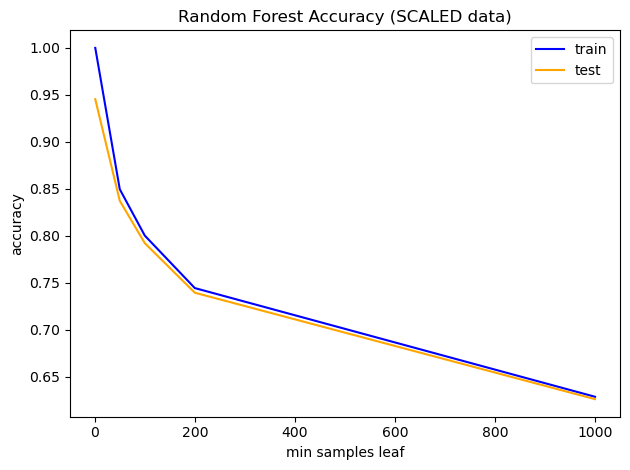

In [115]:
leaf_values = [1, 50, 100, 200, 1000]
train_accs = []
test_accs = []

# Loop over different leaf_values
for l in leaf_values:

    # Instantiate & fit
    random_forest_model = RandomForestClassifier(min_samples_leaf = l, random_state=42)
    random_forest_model.fit(X_train, y_train)

    # Evaluate on train & test data
    train_accs.append(random_forest_model.score(X_train, y_train))
    test_accs.append(random_forest_model.score(X_val, y_val))
    train_score = random_forest_model.score(X_train, y_train)
    test_score = random_forest_model.score(X_val, y_val)
    
    print("l", l, ", train", train_score, ", test", test_score
          , ", diff", train_score - test_score)

# Plot the results
plt.plot(leaf_values, train_accs, c='blue', label='train')
plt.plot(leaf_values, test_accs, c='orange', label='test')
plt.legend()
plt.xlabel('min samples leaf')
plt.ylabel('accuracy')
plt.title('Random Forest Accuracy (SCALED data)')

plt.tight_layout()
plt.show()

**Observation:** <br/>
According to the plot above, the overfitting issue stabilize after `min_samples_leaf` reaches 50.

s 2 , train 0.9999955627481295 , test 0.9452799139935445 , diff 0.05471564875458501
s 50 , train 0.9231791261529724 , test 0.9034430473466553 , diff 0.019736078806317114
s 100 , train 0.8855436235739782 , test 0.870861002715593 , diff 0.014682620858385231
s 200 , train 0.8431963934016797 , test 0.8324775792428288 , diff 0.010718814158850898
s 1000 , train 0.7220448377962578 , test 0.7187396200198282 , diff 0.0033052177764296697


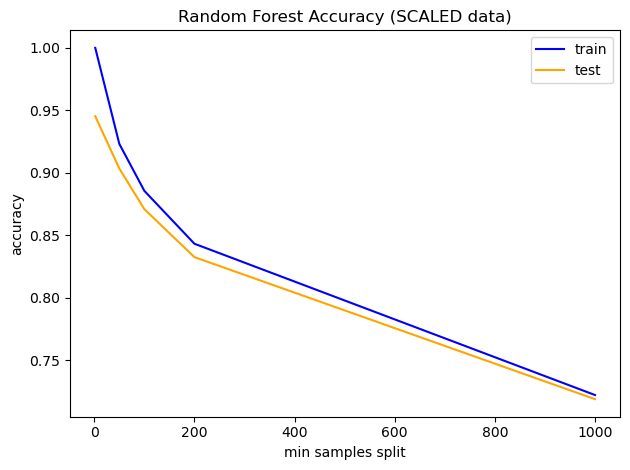

In [116]:
split_values = [2, 50, 100, 200, 1000]
train_accs = []
test_accs = []

# Loop over different split_values
for s in split_values:

    # Instantiate & fit
    random_forest_model = RandomForestClassifier(min_samples_split = s)
    random_forest_model.fit(X_train, y_train)

    # Evaluate on train & test data
    train_accs.append(random_forest_model.score(X_train, y_train))
    test_accs.append(random_forest_model.score(X_val, y_val))
    train_score = random_forest_model.score(X_train, y_train)
    test_score = random_forest_model.score(X_val, y_val)
    
    print("s", s, ", train", train_score, ", test", test_score
          , ", diff", train_score - test_score)

# Plot the results
plt.plot(split_values, train_accs, c='blue', label='train')
plt.plot(split_values, test_accs, c='orange', label='test')
plt.legend()
plt.xlabel('min samples split')
plt.ylabel('accuracy')
plt.title('Random Forest Accuracy (SCALED data)')

plt.tight_layout()
plt.show()

**Observation:** <br/>
According to the plot, the trend of how the accuracy and overfitting issue change along with `min_samples_split` is similar to the previous plot for `min_samples_leaf`.

In [117]:
# Start the timer
start_time = time.time()

# Initialize the model
random_forest_model = RandomForestClassifier(random_state=42)

# Define the hyperparameter grid to search
estimators = {
    'max_depth': [20, 25],
    'min_samples_leaf': [50, 100, 200],
    'min_samples_split': [50, 100, 200]               
}

# Initialize GridSearchCV with the model, parameter grid, and scoring metric: f1-score
grid = GridSearchCV(random_forest_model, estimators, cv=5, scoring='f1_macro', n_jobs=-1)

# Perform the hyperparameter search on the validation data
fittedgrid = grid.fit(X_train, y_train)

# Get the best hyperparameters and the corresponding model
best_params = fittedgrid.best_params_
best_model = fittedgrid.best_estimator_

# Make predictions using the best model
y_pred_random_forest_model_tuned_1 = best_model.predict(X_val)

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Saving metrics for plotting
accuracy_random_forest_model_tuned_1 = accuracy_score(y_val, y_pred_random_forest_model_tuned_1)
precision_random_forest_model_tuned_1 = precision_score(y_val, y_pred_random_forest_model_tuned_1, average='macro')
recall_random_forest_model_tuned_1 = recall_score(y_val, y_pred_random_forest_model_tuned_1, average='macro')
f1_random_forest_model_tuned_1 = f1_score(y_val, y_pred_random_forest_model_tuned_1, average='macro')

# Evaluate its classification accuracy
print('Tuned Random Forest:')
print(f'Train score: {best_model.score(X_train, y_train)}')
print(f'Test score: {best_model.score(X_val, y_val)}')

# Best hyperparameters
print("\nBest Hyperparameters:")
print(best_params) 

# Generate confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred_random_forest_model_tuned_1))

# Classification report 
print("\nClassification Report:")
print(classification_report(y_val, y_pred_random_forest_model_tuned_1))

# Print the elapsed time
print(f"\nElapsed time: {elapsed_time:.2f} seconds")

/Users/chih-kanghsu/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/chih-kanghsu/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/chih-kanghsu/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/chih-kanghsu/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/chih-kanghsu/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked

Tuned Random Forest:
Train score: 0.8450676459047651
Test score: 0.8331571113798812

Best Hyperparameters:
{'max_depth': 25, 'min_samples_leaf': 50, 'min_samples_split': 50}

Confusion Matrix:
[[119764   5421   6666]
 [ 17402  92823  21050]
 [  7316   7946 116001]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.91      0.87    131851
         1.0       0.87      0.71      0.78    131275
         2.0       0.81      0.88      0.84    131263

    accuracy                           0.83    394389
   macro avg       0.84      0.83      0.83    394389
weighted avg       0.84      0.83      0.83    394389


Elapsed time: 10033.80 seconds


#### XGBoost

n_estimators 2 , train 0.5327174427737135 , test 0.5322917221322095 , diff 0.00042572064150392386
n_estimators 100 , train 0.7356760755423114 , test 0.734267436465013 , diff 0.0014086390772983792
n_estimators 200 , train 0.7771079640430464 , test 0.7744637908258091 , diff 0.002644173217237311
n_estimators 500 , train 0.8322718792966068 , test 0.8257786094439754 , diff 0.006493269852631434


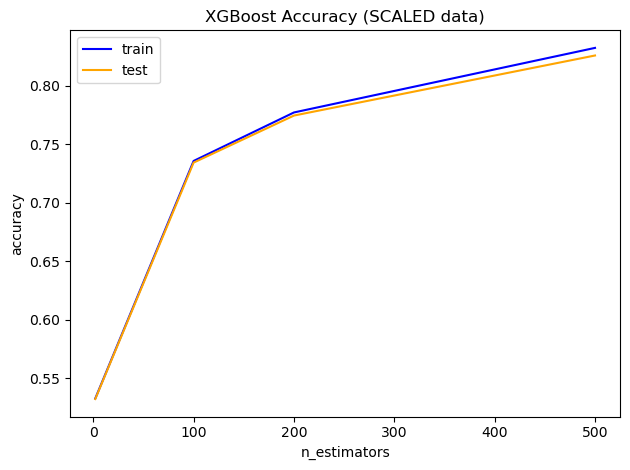

In [160]:
num_estimators = [2, 100, 200, 500]
train_accs = []
test_accs = []

# Loop over different n_estimators
for n in num_estimators:

    # Instantiate & fit
    xgbc = XGBClassifier(n_estimators = n)
    xgbc.fit(X_train, y_train)

    # Evaluate on train & test data
    train_accs.append(xgbc.score(X_train, y_train))
    test_accs.append(xgbc.score(X_val, y_val))
    train_score = xgbc.score(X_train, y_train)
    test_score = xgbc.score(X_val, y_val)
    
    print("n_estimators", n, ", train", train_score, ", test", test_score
          , ", diff", train_score - test_score)

# Plot the results
plt.plot(num_estimators, train_accs, c='blue', label='train')
plt.plot(num_estimators, test_accs, c='orange', label='test')
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.title('XGBoost Accuracy (SCALED data)')

plt.tight_layout()
plt.show()

**Observation:** <br/>
The model starts overfitting where n_estimators > 200.

max_depth 3 , train 0.6403423529985998 , test 0.6404869304164162 , diff -0.0001445774178164827
max_depth 5 , train 0.7072725924263717 , test 0.7069568370314588 , diff 0.0003157553949129088
max_depth 7 , train 0.7738706718569835 , test 0.7705488743347304 , diff 0.003321797522253145
max_depth 13 , train 0.9437318429238194 , test 0.9185854575051535 , diff 0.025146385418665873
max_depth 21 , train 0.9948521539371419 , test 0.9436064393276689 , diff 0.051245714609473025


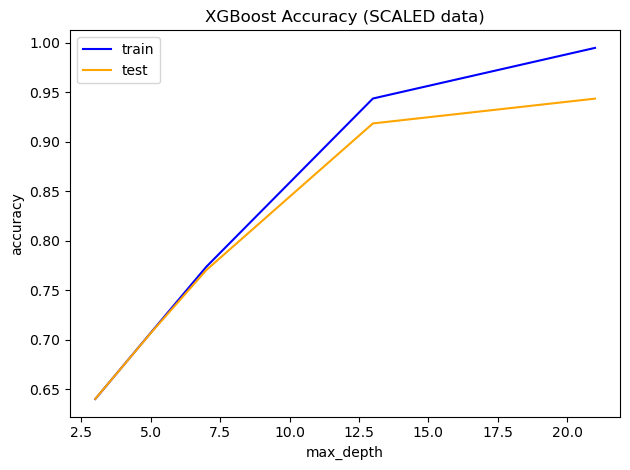

In [161]:
max_depth = [3, 5, 7, 13, 21]
train_accs = []
test_accs = []

# Loop over different max_depths
for d in max_depth:

    # Instantiate & fit
    xgbc = XGBClassifier(max_depth = d)
    xgbc.fit(X_train, y_train)

    # Evaluate on train & test data
    train_accs.append(xgbc.score(X_train, y_train))
    test_accs.append(xgbc.score(X_val, y_val))
    train_score = xgbc.score(X_train, y_train)
    test_score = xgbc.score(X_val, y_val)
    
    print("max_depth", d, ", train", train_score, ", test", test_score
          , ", diff", train_score - test_score)

# Plot the results
plt.plot(max_depth, train_accs, c='blue', label='train')
plt.plot(max_depth, test_accs, c='orange', label='test')
plt.legend()
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.title('XGBoost Accuracy (SCALED data)')

plt.tight_layout()
plt.show()

**Observation:** <br/>
The model starts overfitting where max_depth > 7.

learning_rate 0.01 , train 0.5479201015750342 , test 0.5471831110908266 , diff 0.0007369904842076114
learning_rate 0.1 , train 0.6830864002667423 , test 0.6817989345544627 , diff 0.0012874657122795563
learning_rate 0.2 , train 0.7151385722064488 , test 0.7141654559331015 , diff 0.0009731162733472853
learning_rate 0.5 , train 0.7652820539151458 , test 0.7628711754131073 , diff 0.0024108785020384715
learning_rate 1 , train 0.8049003741871114 , test 0.799763685092637 , diff 0.0051366890944744


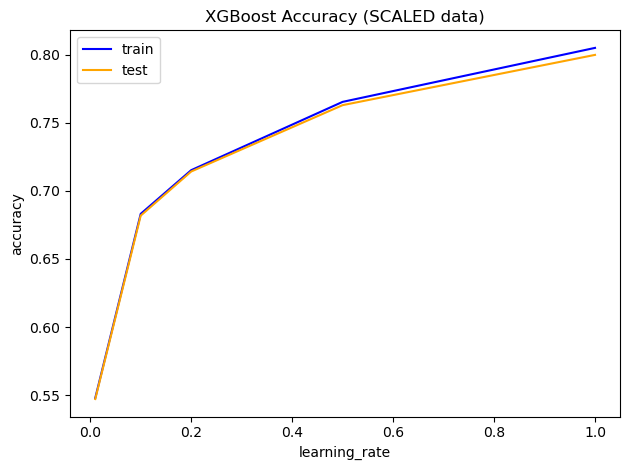

In [162]:
learning_rate = [0.01, 0.1, 0.2, 0.5, 1]
train_accs = []
test_accs = []

# Loop over different learning_rate
for l in learning_rate:

    # Instantiate & fit
    xgbc = XGBClassifier(learning_rate = l)
    xgbc.fit(X_train, y_train)

    # Evaluate on train & test data
    train_accs.append(xgbc.score(X_train, y_train))
    test_accs.append(xgbc.score(X_val, y_val))
    train_score = xgbc.score(X_train, y_train)
    test_score = xgbc.score(X_val, y_val)
    
    print("learning_rate", l, ", train", train_score, ", test", test_score
          , ", diff", train_score - test_score)

# Plot the results
plt.plot(learning_rate, train_accs, c='blue', label='train')
plt.plot(learning_rate, test_accs, c='orange', label='test')
plt.legend()
plt.xlabel('learning_rate')
plt.ylabel('accuracy')
plt.title('XGBoost Accuracy (SCALED data)')

plt.tight_layout()
plt.show()

**Observation:** <br/>
The model starts overfitting where learning_rate > 0.5

In [163]:
# Start the timer
start_time = time.time()

# Initialize the model
xgbc = XGBClassifier()

# Define the hyperparameter grid to search
estimators = {
    'n_estimators': [100, 200, 300], 
    'max_depth': [3, 5, 7],               
    'learning_rate': [0.2, 0.4, 0.5]              
}

# Initialize GridSearchCV with the model, parameter grid, and scoring metric: f1-score
grid = GridSearchCV(xgbc, estimators, cv=5, scoring='f1_macro', n_jobs=-1)

# Perform the hyperparameter search on the validation data
fittedgrid = grid.fit(X_train, y_train)

# Get the best hyperparameters and the corresponding model
best_params = fittedgrid.best_params_
best_model = fittedgrid.best_estimator_

# Get class predictions
y_pred_xgbc_tuned = best_model.predict(X_val)

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Saving metrics for plotting
accuracy_xgbc_tuned = accuracy_score(y_val, y_pred_xgbc_tuned)
precision_xgbc_tuned = precision_score(y_val, y_pred_xgbc_tuned, average='macro')
recall_xgbc_tuned = recall_score(y_val, y_pred_xgbc_tuned, average='macro')
f1_xgbc_tuned = f1_score(y_val, y_pred_xgbc_tuned, average='macro')

# Evaluate its classification accuracy
print('Tuned XGBoost:')
print(f'Train score: {best_model.score(X_train, y_train)}')
print(f'Test score: {best_model.score(X_val, y_val)}')

# Best hyperparameters
print("\nBest Hyperparameters:")
print(best_params) 

# Generate confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred_xgbc_tuned))

# Classification report 
print("\nClassification Report:")
print(classification_report(y_val, y_pred_xgbc_tuned))

# Print the elapsed time
print(f"\nElapsed time: {elapsed_time:.2f} seconds")

/Users/chih-kanghsu/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/chih-kanghsu/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/chih-kanghsu/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/chih-kanghsu/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/chih-kanghsu/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked

Tuned XGBoost:
Train score: 0.873114247191695
Test score: 0.8633658646666109

Best Hyperparameters:
{'learning_rate': 0.5, 'max_depth': 7, 'n_estimators': 300}

Confusion Matrix:
[[113768  11428   6655]
 [  5164 118208   7903]
 [  7062  15675 108526]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.86      0.88    131851
         1.0       0.81      0.90      0.85    131275
         2.0       0.88      0.83      0.85    131263

    accuracy                           0.86    394389
   macro avg       0.87      0.86      0.86    394389
weighted avg       0.87      0.86      0.86    394389


Elapsed time: 3928.11 seconds


## Fit the models with Hyperparameters

#### Logistic Regreesion

In [122]:
# Start the timer
start_time = time.time()

# Initialize the model with a solver that supports both 'l1' and 'l2' penalties
logreg = LogisticRegression(C = 0.001, penalty = 'l1', random_state=42, solver='liblinear')

# Fit the model
logreg.fit(X_train, y_train)

# Make predictions using the best model
y_pred_logreg_tuned = logreg.predict(X_val)

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Saving metrics for plotting
accuracy_logreg_tuned = accuracy_score(y_val, y_pred_logreg_tuned)
precision_logreg_tuned = precision_score(y_val, y_pred_logreg_tuned, average='macro')
recall_logreg_tuned = recall_score(y_val, y_pred_logreg_tuned, average='macro')
f1_logreg_tuned = f1_score(y_val, y_pred_logreg_tuned, average='macro')

# Training and test score
print('Tuned Logistic Regression')
print(f"Train score: {logreg.score(X_train, y_train)}")
print(f"Test score: {logreg.score(X_val, y_val)}")

# Generate confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred_logreg_tuned))

# Classification report 
print("\nClassification Report:")
print(classification_report(y_val, y_pred_logreg_tuned))

# Print the elapsed time
print(f"\nElapsed time: {elapsed_time:.2f} seconds")

Tuned Logistic Regression
Train score: 0.40032949764603787
Test score: 0.39876872833674365

Confusion Matrix:
[[47473 41970 42408]
 [35108 59722 36445]
 [41022 40166 50075]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.38      0.36      0.37    131851
         1.0       0.42      0.45      0.44    131275
         2.0       0.39      0.38      0.38    131263

    accuracy                           0.40    394389
   macro avg       0.40      0.40      0.40    394389
weighted avg       0.40      0.40      0.40    394389


Elapsed time: 11.38 seconds


#### Decision Tree

In [123]:
# Start the timer
start_time = time.time()

# Initialize the model with a solver that supports both 'l1' and 'l2' penalties
dt_model = DecisionTreeClassifier(max_depth=25, min_samples_leaf=50, min_samples_split=50, random_state=42)

# Fit the model
dt_model.fit(X_train, y_train)

# Make predictions using the best model
y_pred_dt_model_tuned = dt_model.predict(X_val)

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Saving metrics for plotting
accuracy_dt_model_tuned = accuracy_score(y_val, y_pred_dt_model_tuned)
precision_dt_model_tuned = precision_score(y_val, y_pred_dt_model_tuned, average='macro')
recall_dt_model_tuned = recall_score(y_val, y_pred_dt_model_tuned, average='macro')
f1_dt_model_tuned = f1_score(y_val, y_pred_dt_model_tuned, average='macro')

# Training and test score
print('Tuned Decision Tree')
print(f"Train score: {dt_model.score(X_train, y_train)}")
print(f"Test score: {dt_model.score(X_val, y_val)}")

# Generate confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred_dt_model_tuned))

# Classification report 
print("\nClassification Report:")
print(classification_report(y_val, y_pred_dt_model_tuned))

# Print the elapsed time
print(f"\nElapsed time: {elapsed_time:.2f} seconds")

Tuned Decision Tree
Train score: 0.8272761675835931
Test score: 0.8120764017252002

Confusion Matrix:
[[111551  11398   8902]
 [ 12726 102733  15816]
 [ 10194  15079 105990]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.85      0.84    131851
         1.0       0.80      0.78      0.79    131275
         2.0       0.81      0.81      0.81    131263

    accuracy                           0.81    394389
   macro avg       0.81      0.81      0.81    394389
weighted avg       0.81      0.81      0.81    394389


Elapsed time: 21.60 seconds


#### Random Forest

In [124]:
# Start the timer
start_time = time.time()

# Initialize the model
random_forest_model = RandomForestClassifier(max_depth=25, min_samples_leaf=50, min_samples_split=50, random_state=42)

# Fit the model
random_forest_model.fit(X_train, y_train)

# Make predictions using the best model
y_pred_random_forest_model_tuned_1 = random_forest_model.predict(X_val)

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Saving metrics for plotting
accuracy_random_forest_model_tuned_1 = accuracy_score(y_val, y_pred_random_forest_model_tuned_1)
precision_random_forest_model_tuned_1 = precision_score(y_val, y_pred_random_forest_model_tuned_1, average='macro')
recall_random_forest_model_tuned_1 = recall_score(y_val, y_pred_random_forest_model_tuned_1, average='macro')
f1_random_forest_model_tuned_1 = f1_score(y_val, y_pred_random_forest_model_tuned_1, average='macro')

# Evaluate its classification accuracy
print('Tuned Random Forest:')
print(f'Train score: {random_forest_model.score(X_train, y_train)}')
print(f'Test score: {random_forest_model.score(X_val, y_val)}')

# Generate confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred_random_forest_model_tuned_1))

# Classification report 
print("\nClassification Report:")
print(classification_report(y_val, y_pred_random_forest_model_tuned_1))

# Print the elapsed time
print(f"\nElapsed time: {elapsed_time:.2f} seconds")

Tuned Random Forest:
Train score: 0.8450676459047651
Test score: 0.8331571113798812

Confusion Matrix:
[[119764   5421   6666]
 [ 17402  92823  21050]
 [  7316   7946 116001]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.91      0.87    131851
         1.0       0.87      0.71      0.78    131275
         2.0       0.81      0.88      0.84    131263

    accuracy                           0.83    394389
   macro avg       0.84      0.83      0.83    394389
weighted avg       0.84      0.83      0.83    394389


Elapsed time: 753.97 seconds


#### XGBoost

In [164]:
# Start the timer
start_time = time.time()

# Initialize the model
xgbc = XGBClassifier(learning_rate=0.5, max_depth=7, n_estimators=300, random_state=42)

# Fit the model
xgbc.fit(X_train, y_train)

# Get class predictions
y_pred_xgbc_tuned = xgbc.predict(X_val)

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Saving metrics for plotting
accuracy_xgbc_tuned = accuracy_score(y_val, y_pred_xgbc_tuned)
precision_xgbc_tuned = precision_score(y_val, y_pred_xgbc_tuned, average='macro')
recall_xgbc_tuned = recall_score(y_val, y_pred_xgbc_tuned, average='macro')
f1_xgbc_tuned = f1_score(y_val, y_pred_xgbc_tuned, average='macro')

# Evaluate its classification accuracy
print('Tuned XGBoost:')
print(f'Train score: {xgbc.score(X_train, y_train)}')
print(f'Test score: {xgbc.score(X_val, y_val)}')

# Generate confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred_xgbc_tuned))

# Classification report 
print("\nClassification Report:")
print(classification_report(y_val, y_pred_xgbc_tuned))

# Print the elapsed time
print(f"\nElapsed time: {elapsed_time:.2f} seconds")

Tuned XGBoost:
Train score: 0.873114247191695
Test score: 0.8633658646666109

Confusion Matrix:
[[113768  11428   6655]
 [  5164 118208   7903]
 [  7062  15675 108526]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.86      0.88    131851
         1.0       0.81      0.90      0.85    131275
         2.0       0.88      0.83      0.85    131263

    accuracy                           0.86    394389
   macro avg       0.87      0.86      0.86    394389
weighted avg       0.87      0.86      0.86    394389


Elapsed time: 65.50 seconds


#### Summary - Tuned Models

Let's review the training and testing scores, as well as the runtime for each tuned model.

| Model               | Train Score (%) | Test Score (%) | Elapsed Time (seconds) |
|---------------------|-----------------|----------------|------------------------|
| Logistic Regression | 40.03%          | 39.87%         | 11.38                  |
| Decision Tree       | 82.72%          | 81.20%         | 21.60                  |
| Random Forest       | 84.50%          | 83.31%         | 753.97                 |
| XGBoost             | 87.31%          | 86.33%         | 65.50                  |

Let's compare the classification report for each tuned model.

In [165]:
# Create an empty DataFrame to store the metrics
tuned_metrics_df = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Add the metrics for the tuned models
tuned_metrics_df.loc['Logistic Regression'] = [accuracy_logreg_tuned, precision_logreg_tuned, recall_logreg_tuned, f1_logreg_tuned]
tuned_metrics_df.loc['Decision Tree'] = [accuracy_dt_model_tuned, precision_dt_model_tuned, recall_dt_model_tuned, f1_dt_model_tuned]
tuned_metrics_df.loc['Random Forest'] = [accuracy_random_forest_model_tuned_1, precision_random_forest_model_tuned_1, recall_random_forest_model_tuned_1, f1_random_forest_model_tuned_1]
tuned_metrics_df.loc['XGBoost'] = [accuracy_xgbc_tuned, precision_xgbc_tuned, recall_xgbc_tuned, f1_xgbc_tuned]

# Show the comparison table
tuned_metrics_df

,Accuracy,Precision,Recall,F1 Score
Logistic Regression,0.398769,0.397823,0.398825,0.397965
Decision Tree,0.812076,0.811844,0.812027,0.811890
Random Forest,0.833157,0.836730,0.833049,0.830766
XGBoost,0.863366,0.866056,0.863366,0.863529


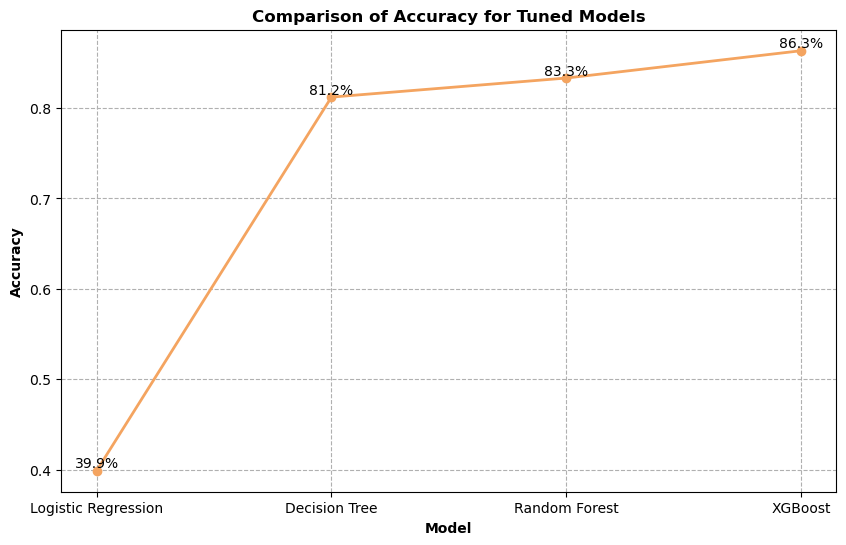

In [166]:
# Creating a list of model names
# Creating a list of model's corresponding accuracy scores
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
accuracy_scores = [accuracy_logreg_tuned, accuracy_dt_model_tuned, accuracy_random_forest_model_tuned_1, accuracy_xgbc_tuned]

# Plotting a line graph to compare the accuracy scores of each model
plt.figure(figsize=(10, 6))
plt.plot(models, accuracy_scores, color='sandybrown', marker='o', linestyle='-', linewidth=2)
plt.xlabel('Model', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.title('Comparison of Accuracy for Tuned Models', fontweight='bold')

# Add accuracy score labels
for i, score in enumerate(accuracy_scores):
    plt.text(models[i], score, f"{score*100:.1f}%", ha='center', va='bottom')

# Add grid lines
plt.grid(True, which='both', linestyle='--')  
plt.show()

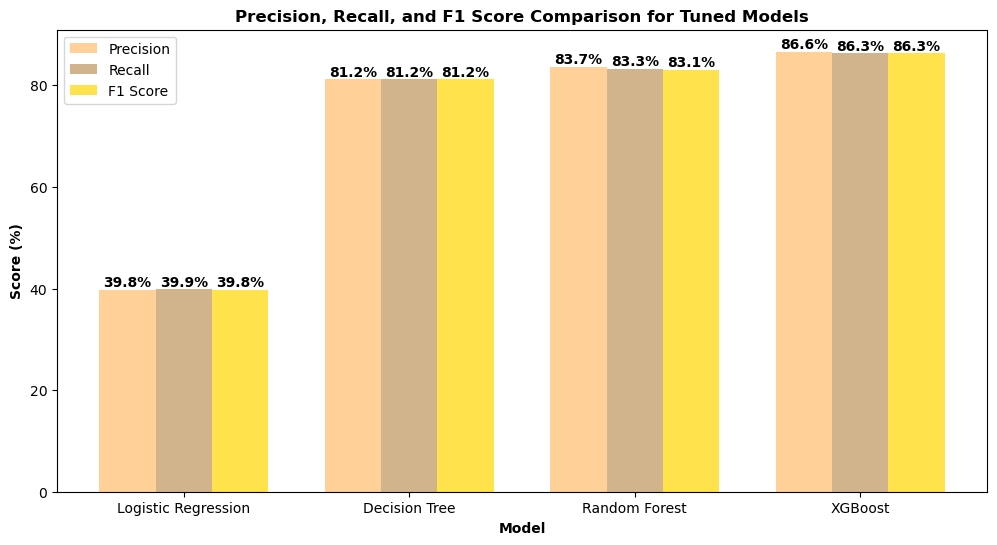

In [167]:
# Creating a list of model names
# Creating a list of model's corresponding precision, recall, and F1 scores
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
precision_scores = [precision_logreg_tuned, precision_dt_model_tuned, precision_random_forest_model_tuned_1, precision_xgbc_tuned]
recall_scores = [recall_logreg_tuned, recall_dt_model_tuned, recall_random_forest_model_tuned_1, recall_xgbc_tuned]
f1_scores = [f1_logreg_tuned, f1_dt_model_tuned, f1_random_forest_model_tuned_1, f1_xgbc_tuned]

# Converting scores to percentages with two decimal place
precision_scores_pct = [round(score * 100, 2) for score in precision_scores]
recall_scores_pct = [round(score * 100, 2) for score in recall_scores]
f1_scores_pct = [round(score * 100, 2) for score in f1_scores]

# Set the positions and width for the bars
pos = np.arange(len(models))
width = 0.25

# Plotting the bar graph for precision with an orange color theme
plt.figure(figsize=(12, 6))
plt.bar(pos, precision_scores_pct, width, color='darkorange', alpha=0.4, label='Precision')

# Plotting the bar graph for recall with a darker orange color
plt.bar(pos + width, recall_scores_pct, width, color='tan', label='Recall')

# Plotting the bar graph for F1 score with a much darker orange color
plt.bar(pos + 2 * width, f1_scores_pct, width, color='gold', alpha=0.7, label='F1 Score')

# Add xticks on the middle of the group bars
plt.xlabel('Model', fontweight='bold')
plt.ylabel('Score (%)', fontweight='bold')
plt.title('Precision, Recall, and F1 Score Comparison for Tuned Models', fontweight='bold')
plt.xticks(pos + width, models, rotation=360)
plt.legend()

# Adding score labels to the bars
for i in range(len(models)):
    plt.text(pos[i], precision_scores_pct[i], f"{precision_scores_pct[i]:.1f}%", ha='center', va='bottom', fontweight='bold')
    plt.text(pos[i] + width, recall_scores_pct[i], f"{recall_scores_pct[i]:.1f}%", ha='center', va='bottom', fontweight='bold')
    plt.text(pos[i] + 2 * width, f1_scores_pct[i], f"{f1_scores_pct[i]:.1f}%", ha='center', va='bottom', fontweight='bold')

plt.show()

## Compare Baseline Models and Tuned Models

First, let's compare the train and test scores, as well as the runtime, for the baseline and tuned models.

**Baseline Models:**
| Model               | Train Score (%) | Test Score (%) | Elapsed Time (seconds) |
|---------------------|-----------------|----------------|------------------------|
| Logistic Regression | 40.00%          | 39.85%         | 3.49                   |
| Decision Tree       | 100.00%         | 92.27%         | 24.77                  |
| Random Forest       | 99.99%          | 94.53%         | 876.24                 |
| XGBoost             | 73.56%          | 73.42%         | 21.13                  |
<br/>

**Tuned Models:**
| Model               | Train Score (%) | Test Score (%) | Elapsed Time (seconds) |
|---------------------|-----------------|----------------|------------------------|
| Logistic Regression | 40.03%          | 39.87%         | 11.38                  |
| Decision Tree       | 82.72%          | 81.20%         | 21.60                  |
| Random Forest       | 84.50%          | 83.31%         | 753.97                 |
| XGBoost             | 87.31%          | 86.33%         | 65.50                  |

Additionally, we can compare the accuracy, precision, recall, and F1 scores for both the baseline and tuned models.

In [168]:
print("Baseline Models:")
print(model_metrics_df)

print("\nTuned Models:")
print(tuned_metrics_df)

Baseline Models:
                     Accuracy  Precision    Recall  F1 Score
Logistic Regression  0.398573   0.397752  0.398631  0.397902
Decision Tree        0.922726   0.922721  0.922719  0.922720
Random Forest        0.945364   0.945339  0.945349  0.945334
XGBoost              0.734267   0.746696  0.734322  0.732693

Tuned Models:
                     Accuracy  Precision    Recall  F1 Score
Logistic Regression  0.398769   0.397823  0.398825  0.397965
Decision Tree        0.812076   0.811844  0.812027  0.811890
Random Forest        0.833157   0.836730  0.833049  0.830766
XGBoost              0.863366   0.866056  0.863366  0.863529


## ROC AUC Curve

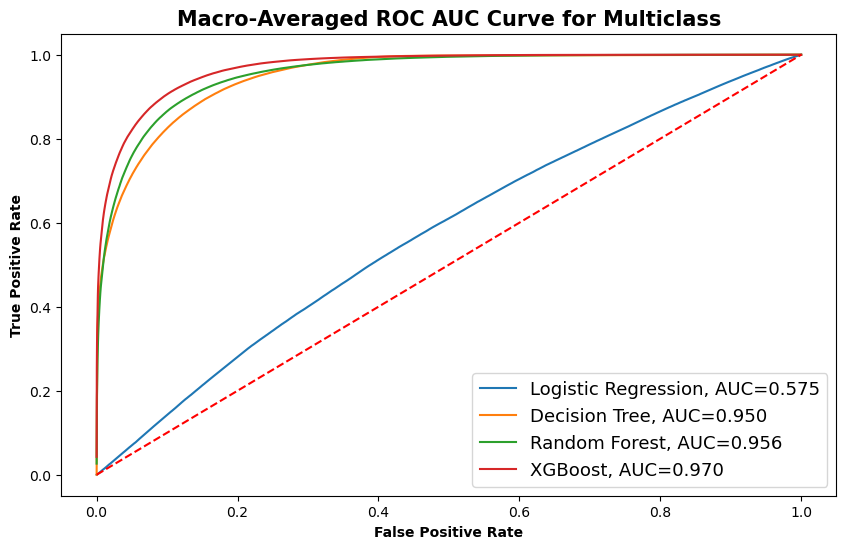

In [169]:
from sklearn.preprocessing import label_binarize

# Binarize the output for multiclass
y_val_binarized = label_binarize(y_val, classes=[0, 1, 2])
n_classes = y_val_binarized.shape[1]

# Define a list to store the results for each model
model_results = []

# Define a function to compute the macro-average ROC curve
def compute_macro_avg_roc_auc(model_name, model, X_val, y_val_binarized, n_classes):
    # Store all false positive rates and true positive rates
    all_fpr = np.unique(np.concatenate([roc_curve(y_val_binarized[:, i], model.predict_proba(X_val)[:, i])[0] for i in range(n_classes)]))

    # Initialize mean true positive rate (tpr)
    mean_tpr = np.zeros_like(all_fpr)

    # Compute mean tpr by interpolating all roc curves
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_val_binarized[:, i], model.predict_proba(X_val)[:, i])
        mean_tpr += np.interp(all_fpr, fpr, tpr)
    
    # Average it
    mean_tpr /= n_classes

    # Compute macro average AUC
    roc_auc = auc(all_fpr, mean_tpr)
    
    # Append results
    model_results.append((model_name, roc_auc, all_fpr, mean_tpr))

# Logistic Regression
compute_macro_avg_roc_auc('Logistic Regression', logreg, X_val, y_val_binarized, n_classes)

# Decision Tree
compute_macro_avg_roc_auc('Decision Tree', dt_model, X_val, y_val_binarized, n_classes)

# Random Forest
compute_macro_avg_roc_auc('Random Forest', random_forest_model, X_val, y_val_binarized, n_classes)

# XGBoost
compute_macro_avg_roc_auc('XGBoost', xgbc, X_val, y_val_binarized, n_classes)

# Plot the ROC AUC curve with index labeling
fig = plt.figure(figsize=(10, 6))

for name, auc_score, fpr_val, tpr_val in model_results:
    plt.plot(fpr_val, tpr_val, label="{}, AUC={:.3f}".format(name, auc_score))

plt.plot([0, 1], [0, 1], 'r--')

plt.xlabel("False Positive Rate", fontweight='bold')
plt.ylabel("True Positive Rate", fontweight='bold')

plt.title('Macro-Averaged ROC AUC Curve for Multiclass', fontweight='bold', fontsize=15)
plt.legend(prop={'size': 13}, loc='lower right')

plt.show()

According to the ROC AUC Curve:

* The "Decision Tree," "Random Forest," and "XGBoost" models exhibit similar performance, as their ROC curves are closely aligned with comparable AUC scores.
* The "XGBoost" model achieves the highest AUC score of 0.970, indicating the best performance on the test data.
* The "Logistic Regression" model has the lowest AUC score at 0.575, suggesting it performs the poorest among the models.
* Based on these results, the "XGBoost" model appears to be the most effective choice for this evaluation.

In [ ]:
# This code will show ROC AUC Curve for each class in each model

#from sklearn.preprocessing import label_binarize

# Binarize the output (for multiclass case)
#y_val_binarized = label_binarize(y_val, classes=[0, 1, 2])
#n_classes = y_val_binarized.shape[1]

# Define a list to store the results for each model
#model_results = []

# Define a function to compute the ROC curve for each class
#def compute_roc_auc(model_name, model, X_val, y_val_binarized, n_classes):
#    for i in range(n_classes):
#        fpr, tpr, thresholds = roc_curve(y_val_binarized[:, i], model.predict_proba(X_val)[:, i])
#        roc_auc = auc(fpr, tpr)
#       model_results.append((f"{model_name} (Class {i})", roc_auc, fpr, tpr))

# Logistic Regression
#compute_roc_auc('Logistic Regression', logreg, X_val, y_val_binarized, n_classes)

# Decision Tree
#compute_roc_auc('Decision Tree', dt_model, X_val, y_val_binarized, n_classes)

# Random Forest
#compute_roc_auc('Random Forest', random_forest_model, X_val, y_val_binarized, n_classes)

# XGBoost
#compute_roc_auc('XGBoost', xgbc, X_val, y_val_binarized, n_classes)

# Plot the ROC AUC curve with index labeling
#fig = plt.figure(figsize=(10, 6))

#for name, auc_score, fpr_val, tpr_val in model_results:
#    plt.plot(fpr_val, tpr_val, label="{}, AUC={:.3f}".format(name, auc_score))

#plt.plot([0, 1], [0, 1], 'r--')

#plt.xlabel("False Positive Rate", fontweight='bold')
#plt.ylabel("True Positive Rate", fontweight='bold')

#plt.title('ROC AUC Curve', fontweight='bold', fontsize=15)
#plt.legend(prop={'size': 10}, loc='lower right')

#plt.show()

## Model Selection

**XGBoost Model**

The F1 score is the harmonic mean of precision and recall, providing a balanced measure of both metrics. Since our goal is to both identify as many correct usage rate categories as possible (high recall) and maintain accuracy in our predictions (high precision), the F1 score is an ideal metric to evaluate.

In this context, the tuned XGBoost model achieves the highest F1 score, indicating it offers the best balance between precision and recall among all the models we've trained. This model effectively captures a high proportion of actual usage rates while maintaining strong predictive accuracy.

Therefore, the tuned XGBoost model is the preferred choice based on the F1 score, as it offers the optimal balance between precision and recall.

## Model Evaluation

**XGBoost Model**

In [170]:
# Initialize the model
final_xgbc_model = XGBClassifier(learning_rate=0.5, max_depth=7, n_estimators=300, random_state=42)

# Fit the model with X_train_full and y_train_full which held the data I split into train and validation
final_xgbc_model.fit(X_train_full, y_train_full)

# Make predictions on the test data using random forest model that we trained from above
y_test_pred = final_xgbc_model.predict(X_test)

# Compute the metrics
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred, average='macro')
recall_test = recall_score(y_test, y_test_pred, average='macro')
f1_test = f1_score(y_test, y_test_pred, average='macro')

# Evaluate its classification accuracy
print('Tuned XGBoost:')
print(f'Train score: {final_xgbc_model.score(X_train, y_train)}')
print(f'Test score: {final_xgbc_model.score(X_test, y_test)}')

# Generate confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

# Classification report 
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

print("Test Precision: ", precision_test)
print("Test Recall: ", recall_test)
print("Test F1 Score: ", f1_test)

Tuned XGBoost:
Train score: 0.8729532383381097
Test score: 0.8211063001623184

Confusion Matrix:
[[ 20015  11077    394]
 [  6194 148274   9826]
 [   379  15884  32538]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.64      0.69     31486
         1.0       0.85      0.90      0.87    164294
         2.0       0.76      0.67      0.71     48801

    accuracy                           0.82    244581
   macro avg       0.79      0.73      0.76    244581
weighted avg       0.82      0.82      0.82    244581

Test Precision:  0.7866357872069879
Test Recall:  0.7349732853584007
Test F1 Score:  0.7578192381702206


**Train and Test Scores:**
* The Tuned XGBoost model shows a strong performance with a train score of 0.873 and a test score of 0.821, indicating good generalization to unseen data.

**Confusion Matrix and Classification Report:**
* Class 0 (Low Usage Rate): The model correctly predicted 20,015 instances but misclassified 11,077 as Class 1 and 394 as Class 2. This class has the lowest recall (0.64), meaning it struggled to identify all instances of this class.
* Class 1 (Medium Usage Rate): This class had the best performance, with 148,274 correctly classified instances and the highest precision (0.85) and recall (0.90). This indicates strong model confidence and accuracy in predicting this class.
* Class 2 (High Usage Rate): The model correctly identified 32,538 instances but misclassified 15,884 as Class 1. The recall of 0.67 suggests that the model missed some instances of this class.

**Overall Metrics:**
* Precision: The overall precision of 0.79 indicates that the model is fairly accurate in its predictions, with fewer false positives.
* Recall: The recall of 0.73 shows that the model is effective at identifying most true positives but misses some instances, particularly in Class 0.
* F1-Score: The F1-score of 0.76 reflects a balanced trade-off between precision and recall across all classes.

**Summary:**<br/>
The Tuned XGBoost model performs well, particularly for Class 1, where it exhibits high precision and recall. The model shows good overall accuracy, with an 82% test score, indicating that it is well-suited for the task, although there is room for improvement, especially in accurately classifying instances of Class 0 and Class 2.

## Save the Tuned Models

In [ ]:
# Specify the directory
directory = './model/'

# Save Logistic Regression model
with open(os.path.join(directory, 'logistic_regression_model.pkl'), 'wb') as file:
    pickle.dump(logreg, file)

# Save Decision Tree model
with open(os.path.join(directory, 'decision_tree_model.pkl'), 'wb') as file:
    pickle.dump(dt_model, file)

# Save Random Forest model
with open(os.path.join(directory, 'random_forest_model.pkl'), 'wb') as file:
    pickle.dump(random_forest_model, file)

# Save XGBoost model
with open(os.path.join(directory, 'xgboost_model.pkl'), 'wb') as file:
    pickle.dump(xgbc, file)